In [1]:
import math

import random as rd
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.collections as mc

In [2]:
SEED = 1
rd.seed(SEED)

In [3]:
def generate_data(count):
    x = []
    y = []

    for i in range(0, count):
        x.append(rd.randrange(1000)/100.0)
        y.append(rd.randrange(1000)/100.0)

    return pd.DataFrame({'x': x, 'y': y})

,x,y
0,1.37,5.82
1,8.67,8.21
2,7.82,0.64
3,2.61,1.20
4,5.07,7.79
5,4.60,4.83
6,6.67,3.88
7,8.07,2.14
8,0.96,4.99
9,0.29,9.14


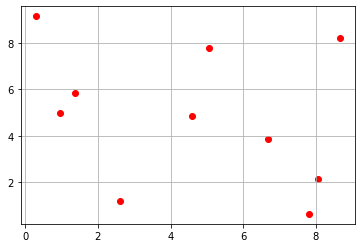

In [4]:
npoints = 10

points = generate_data(npoints)
plt.scatter(points['x'], points['y'], c='r')
plt.grid(True)
points

In [5]:
points.to_csv("points.csv")

In [6]:
points = pd.read_csv("points.csv", index_col=0)
points

,x,y
0,1.37,5.82
1,8.67,8.21
2,7.82,0.64
3,2.61,1.20
4,5.07,7.79
5,4.60,4.83
6,6.67,3.88
7,8.07,2.14
8,0.96,4.99
9,0.29,9.14


In [7]:
def get_edge_ids():
    if SEED == 1:
        return pd.DataFrame({
            'start':[0, 0, 4, 4, 6, 6, 2, 2],
            'end'  :[9, 8, 5, 1, 5, 1, 3, 7]
        })

def get_connectivity_marker():
    ret = {}
    
edgeIds = get_edge_ids()
edgeIds

,start,end
0,0,9
1,0,8
2,4,5
3,4,1
4,6,5
5,6,1
6,2,3
7,2,7


In [8]:
def generate_edge_point(i, j):
    return [
        [points['x'][i], points['x'][j]],
        [points['y'][i], points['y'][j]]
    ]

def generate_edge_point_raw(p1, p2):
    return [
        [p1[0], p2[0]],
        [p1[1], p2[1]]
    ]

In [9]:
def get_angle(point):
    x = point[0]
    y = point[1]
    size = math.sqrt(x*x + y*y)
    angle = math.acos(x/size)*180/math.pi
    
    if y < 0:
        angle = 360 - angle
        
    return angle

In [10]:
def normalize_vector(point):
    x = point[0]
    y = point[1]
    size = math.sqrt(x*x + y*y)
    return [x/size, y/size]

In [11]:
def add_vector_to_point(point, vector, size):
    vector = normalize_vector(vector)
    return [point[0] + vector[0]*size, point[1] + vector[1]*size]

In [12]:
def rotate_point(base, point, angle):
    s = math.sin(angle*math.pi/180)
    c = math.cos(angle*math.pi/180)
    
    x = point[0] - base[0]
    y = point[1] - base[1]
    
    return [
        x*c - y*s + base[0],
        x*s + y*c + base[1]
    ]

In [13]:
def check_in_angle_range(start, end, angle):
    if (angle >= start) and (angle <= end):
        return True
    
    angle = angle - 360
    
    if (angle >= start) and (angle <= end):
        return True
    
    return False

In [14]:
DATA_POINT_COLOR_DEFAULT = 'lightblue'
DATA_POINT_COLOR_SEMI = 'blue'
DATA_POINT_COLOR_VIEW = 'black'
DATA_EDGE_COLOR = 'lightblue'

ORIGIN_COLOR = 'lime'
VIEWPOINT_COLOR = 'orange'
VIEWPOINT_EDGE_COLOR = 'orange'

AXIS_POINT_COLOR = 'lightgreen'
AXIS_EDGE_COLOR = 'lightgreen'

In [15]:
FOV = 70
RADIUS = 5

ORIGIN = [4, 4.5]
DIRECTION = [1, 1]

base_angle = get_angle(DIRECTION)

viewpoint = add_vector_to_point(ORIGIN, DIRECTION, RADIUS)

viewpoint_begin = rotate_point(ORIGIN, viewpoint, FOV/2)
viewpoint_end = rotate_point(ORIGIN, viewpoint, -FOV/2)

axis_xp = rotate_point(ORIGIN, viewpoint, -90)
axis_xn = rotate_point(ORIGIN, viewpoint, 90)

In [16]:
def tag_points():
    colors = [DATA_POINT_COLOR_DEFAULT]*len(points)

    reference_angle = get_angle(DIRECTION)
    semicircle_angle_start = reference_angle - 90
    semicircle_angle_end = reference_angle + 90
    fov_angle_start = reference_angle - FOV/2
    fov_angle_end = reference_angle + FOV/2

    for index, row in points.iterrows():
        angle = get_angle([row['x'] - ORIGIN[0], row['y'] - ORIGIN[1]])

        if(check_in_angle_range(fov_angle_start, fov_angle_end, angle)):
            colors[index] = DATA_POINT_COLOR_VIEW
        elif check_in_angle_range(semicircle_angle_start, semicircle_angle_end, angle):
            colors[index] = DATA_POINT_COLOR_SEMI
    
    return colors

colors = tag_points()

In [17]:
def plot_point(point, color, text=""):
    plt.scatter(point[0], point[1], c=color)
    plt.text(point[0] + 0.1, point[1] + 0.1, text)

In [18]:
def plot_edge(p1, p2, color):
    p = generate_edge_point_raw(p1, p2)
    plt.plot(p[0], p[1], linestyle="--", c=color)

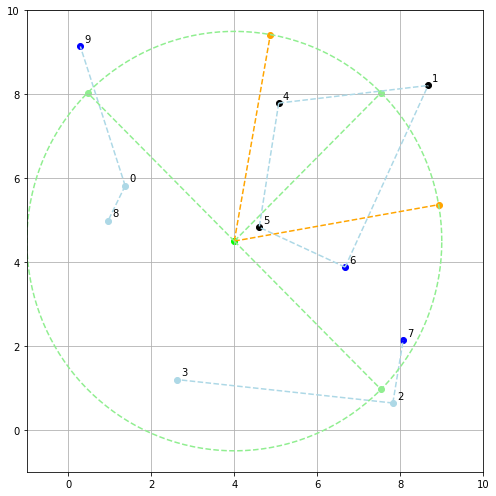

In [19]:
def plot_situation():
    plt.rcParams["figure.autolayout"] = True

    # Plot the building edges
    for index, edge_id in edgeIds.iterrows():
        plot_edge(points.iloc[edge_id[0]], points.iloc[edge_id[1]], DATA_EDGE_COLOR)

    # Plot the points
    for index, row in points.iterrows():
        plot_point([row['x'], row['y']], colors[index], index)

    # Plot the origin
    plt.scatter(ORIGIN[0], ORIGIN[1], c=ORIGIN_COLOR)

    # Plot the point of view
    plot_point(viewpoint, AXIS_POINT_COLOR)
    plot_point(viewpoint_begin, VIEWPOINT_COLOR)
    plot_point(viewpoint_end, VIEWPOINT_COLOR)
    plot_point(axis_xp, AXIS_POINT_COLOR)
    plot_point(axis_xn, AXIS_POINT_COLOR)
    
    plot_edge(ORIGIN, viewpoint, AXIS_EDGE_COLOR)
    plot_edge(ORIGIN, viewpoint_begin, VIEWPOINT_EDGE_COLOR)
    plot_edge(ORIGIN, viewpoint_end, VIEWPOINT_EDGE_COLOR)
    plot_edge(ORIGIN, axis_xp, AXIS_EDGE_COLOR)
    plot_edge(ORIGIN, axis_xn, AXIS_EDGE_COLOR)
    
    angle = np.linspace(0, 2*math.pi, 150) 

    x = RADIUS*np.cos(angle) + ORIGIN[0]
    y = RADIUS*np.sin(angle) + ORIGIN[1]

    plt.plot(x, y, linestyle="--", c=AXIS_EDGE_COLOR)
    
    plt.grid(True)
    plt.xlim(-1, 10)
    plt.ylim(-1, 10)

    fig = plt.gcf()
    fig.set_size_inches(7,7)
    plt.show()
    
plot_situation()